## 0 - Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks')
%pwd

'/content/drive/MyDrive/Colab Notebooks'

# 0. Trasnfer Learning  

- Model Inference Process
 1. Load Data
 2. Trainig the model
 3. Finetuning the CNN
 4. Save and Load model
 5. CNN as fixed feature extractor


# 1. Load Data

- We will use torchvision and torch.utils.data packages for loading the data.

- The problem we’re going to solve today is to train a model to classify cats and dogs. We have about 1000 training images each for cats and dogs. There are 500 validation images for each class.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/data/data'
print(os.path.join(data_dir, 'train'))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#print(image_datasets)
print("train :", len(image_datasets['train']))
print("val :", len(image_datasets['val']))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content/drive/MyDrive/Colab Notebooks/data/data/train
train : 2000
val : 1000


 - **Visualize a few images** : Let’s visualize a few training images so as to understand the data augmentations.



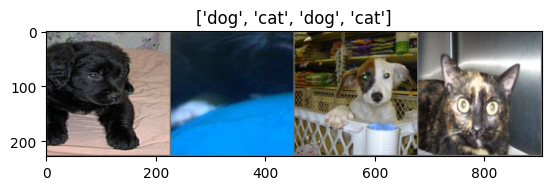

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 2. Training the model

- **Defining train_model function for a general function**. Here, we will illustrate:
 - Scheduling the learning rate
 - Saving the best model

- In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  #with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

 - **Visualizing the model predictions** : Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#3. Finetuning the convnet

- Load a pretrained model and reset final fully connected layer.

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# 입력 크기 지정
input_shape = (3, 224, 224)

# 모델의 입력 크기 변경
vgg16.features[0] = torch.nn.Conv2d(input_shape[0], 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

for name, para in vgg16.named_modules():
  print(f"{name}:*:{para}")

:*:VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
for param in vgg16.parameters():
  print(f"required_grad:{param.requires_grad}")

required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True


In [ ]:
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# VGG-16 모델의 마지막 fully connected (FC) 레이어의 입력 크기 가져오기
num_ftrs = model_conv.classifier[6].in_features

# VGG-16 모델의 마지막 fully connected (FC) 레이어 수정
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 최종 레이어의 파라미터만 최적화 (requires_grad = True)
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# 7 에포크마다 학습률(LR)을 0.1씩 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train**

In [ ]:
model_ft_final = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1799 Acc: 0.9305
val Loss: 0.0378 Acc: 0.9890

Epoch 1/24
----------
train Loss: 0.1625 Acc: 0.9425
val Loss: 0.0431 Acc: 0.9870

Epoch 2/24
----------
train Loss: 0.1816 Acc: 0.9415
val Loss: 0.0842 Acc: 0.9740

Epoch 3/24
----------
train Loss: 0.1847 Acc: 0.9415
val Loss: 0.0360 Acc: 0.9900

Epoch 4/24
----------
train Loss: 0.1553 Acc: 0.9495
val Loss: 0.0408 Acc: 0.9890

Epoch 5/24
----------
train Loss: 0.1663 Acc: 0.9530
val Loss: 0.0371 Acc: 0.9880

Epoch 6/24
----------
train Loss: 0.1672 Acc: 0.9535
val Loss: 0.0364 Acc: 0.9860

Epoch 7/24
----------
train Loss: 0.1326 Acc: 0.9630
val Loss: 0.0378 Acc: 0.9860

Epoch 8/24
----------
train Loss: 0.1639 Acc: 0.9525
val Loss: 0.0360 Acc: 0.9870

Epoch 9/24
----------
train Loss: 0.1628 Acc: 0.9510
val Loss: 0.0348 Acc: 0.9870

Epoch 10/24
----------
train Loss: 0.1180 Acc: 0.9620
val Loss: 0.0375 Acc: 0.9840

Epoch 11/24
----------
train Loss: 0.1704 Acc: 0.9540
val Loss: 0.0361 Acc: 0.9850

Ep

- **Evaluate** : Let’s  display predictions for a few images

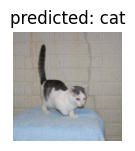

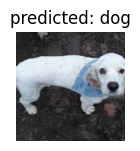

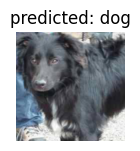

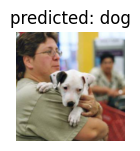

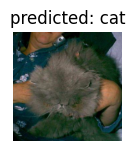

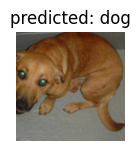

In [ ]:
visualize_model(model_ft_final)

#4. Saving & Loading trained Model  

In [ ]:
# Save model
torch.save(model_ft_final.state_dict(), "model.pth")

# Load model
model_ft_final.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

#5. Hyperparamater tuning 및 모델 성능 변화 확인


---
**Ex 1. Learning rate = 0.05**

기존의 0.001에서 0.05로 큰값을 부여하였다. 큰 값의 학습률은 빠른 수렴을 도와줄 수 있지만, 잘못하면 수렴하지 못하고 발산할 수 있다.

In [ ]:
# 힉습률 감소를 비활성하는 코드
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  #with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv1 = torchvision.models.vgg16(pretrained=True)
for param in model_conv1.parameters():
    param.requires_grad = False

# VGG-16 모델의 마지막 fully connected (FC) 레이어의 입력 크기 가져오기
num_ftrs1 = model_conv1.classifier[6].in_features

# VGG-16 모델의 마지막 fully connected (FC) 레이어 수정
model_conv1.classifier[6] = nn.Linear(num_ftrs1, 2)

model_conv1 = model_conv1.to(device)

criterion1 = nn.CrossEntropyLoss()

In [ ]:
optimizer_conv1 = optim.SGD(model_conv1.classifier.parameters(), lr=0.05, momentum=0.9)

In [ ]:
# 전체 데이터셋을 5 번 반복 (연산 속도 줄이기 위함)
model_ft1 = train_model(model_conv1, criterion1, optimizer_conv1, None, num_epochs=5) # 학습률 감소 비활성화

Epoch 0/4
----------
train Loss: 6.0140 Acc: 0.9270
val Loss: 2.5822 Acc: 0.9730

Epoch 1/4
----------
train Loss: 10.4140 Acc: 0.9170
val Loss: 1.2398 Acc: 0.9820

Epoch 2/4
----------
train Loss: 7.1465 Acc: 0.9435
val Loss: 1.5913 Acc: 0.9840

Epoch 3/4
----------
train Loss: 8.3745 Acc: 0.9455
val Loss: 2.2951 Acc: 0.9830

Epoch 4/4
----------
train Loss: 7.9371 Acc: 0.9490
val Loss: 1.5962 Acc: 0.9850

Training complete in 2m 17s
Best val Acc: 0.985000


---
**Ex 2. Learning rate = 0.0001**

기존의 0.001에서 0.0001로 작은 값을 부여하였다. 작은 값의 학습률은 느린 수렴을 유도하지만, 더 정확한 결과를 얻을 수 있다.

In [ ]:
model_conv2 = torchvision.models.vgg16(pretrained=True)
for param in model_conv2.parameters():
    param.requires_grad = False

# VGG-16 모델의 마지막 fully connected (FC) 레이어의 입력 크기 가져오기
num_ftrs2 = model_conv2.classifier[6].in_features

# VGG-16 모델의 마지막 fully connected (FC) 레이어 수정
model_conv2.classifier[6] = nn.Linear(num_ftrs2, 2)

model_conv2 = model_conv2.to(device)

criterion2 = nn.CrossEntropyLoss()

In [ ]:
optimizer_conv2 = optim.SGD(model_conv2.classifier.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
# 전체 데이터셋을 5 번 반복 (연산 속도 줄이기 위함)
model_ft2 = train_model(model_conv2, criterion2, optimizer_conv2, None, num_epochs=5) # 학습률 감소 비활성화

Epoch 0/4
----------
train Loss: 0.1894 Acc: 0.9235
val Loss: 0.0500 Acc: 0.9870

Epoch 1/4
----------
train Loss: 0.1230 Acc: 0.9510
val Loss: 0.0415 Acc: 0.9880

Epoch 2/4
----------
train Loss: 0.1037 Acc: 0.9590
val Loss: 0.0366 Acc: 0.9910

Epoch 3/4
----------
train Loss: 0.1108 Acc: 0.9560
val Loss: 0.0324 Acc: 0.9910

Epoch 4/4
----------
train Loss: 0.1066 Acc: 0.9550
val Loss: 0.0335 Acc: 0.9870

Training complete in 2m 17s
Best val Acc: 0.991000


---
**Ex 3. weight_decay=0.01**

옵티마이저에 가중치 감쇠를 적용하여 손실 함수의 항에 가중치의 제곱에 해당하는 값을 추가함. 이로써 모델의 가중치를 작게 유지하고, 과적합을 줄이며, 일반화 능력을 향상시킬 수 있음.
default 값은 0 이다.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  #with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv3 = torchvision.models.vgg16(pretrained=True)
for param in model_conv3.parameters():
    param.requires_grad = False

# VGG-16 모델의 마지막 fully connected (FC) 레이어의 입력 크기 가져오기
num_ftrs3 = model_conv3.classifier[6].in_features

# VGG-16 모델의 마지막 fully connected (FC) 레이어 수정
model_conv3.classifier[6] = nn.Linear(num_ftrs3, 2)

model_conv3 = model_conv3.to(device)

criterion3 = nn.CrossEntropyLoss()

In [ ]:
optimizer_conv3 = optim.SGD(model_conv3.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer_conv3, step_size=7, gamma=0.1)

In [ ]:
# 전체 데이터셋을 5 번 반복 (연산 속도 줄이기 위함)
model_ft3 = train_model(model_conv3, criterion3, optimizer_conv3, exp_lr_scheduler3, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1859 Acc: 0.9250
val Loss: 0.0503 Acc: 0.9820

Epoch 1/4
----------
train Loss: 0.1872 Acc: 0.9380
val Loss: 0.0715 Acc: 0.9760

Epoch 2/4
----------
train Loss: 0.1766 Acc: 0.9425
val Loss: 0.0331 Acc: 0.9850

Epoch 3/4
----------
train Loss: 0.1934 Acc: 0.9410
val Loss: 0.0457 Acc: 0.9860

Epoch 4/4
----------
train Loss: 0.1550 Acc: 0.9500
val Loss: 0.0354 Acc: 0.9860

Training complete in 2m 17s
Best val Acc: 0.986000
